# Explore Input Data

Explore preprocessed covid data before we applying topic modelling.

## About data

- Number of Unique COVID articles: 480,297
- Number of English articles: 414,050
- Range of date: 25/07/2002 - 28/02/2022
- Number of articles after preprocessing: 413,915 (we miss some articles if article has no abstract and have title  with composition of stop words)


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
INPUT_PATH = '../data/outputs/articles/'

## Load Data

In [154]:
covid_df = pd.read_csv(INPUT_PATH + "covid_articles.tsv", sep='\t', encoding='utf-8')

In [155]:
# Merge two dataframes to get all attributes for filtered covid articles.

pd.options.display.max_columns = None
df = pd.merge(covid_df, preprocessed_df, on='_id', how='right')
print(df.shape)

(413915, 143)


In [5]:
covid_df.head()

,_id,abstract,URL,member,score,created,update-policy,license,ISSN,container-title,issued,prefix,reference-count,indexed,author,DOI,is-referenced-by-count,published,published-print,alternative-id,subject,published-online,content-domain,reference,title,link,source,type,publisher,volume,references-count,issn-type,deposited,page,short-container-title,import-source,last-updated,issue,journal-issue,published-other,funder,assertion,posted,subtype,accepted,group-title,institution,editor,original-title,subtitle,archive,relation,article-number,event,update-to,clinical-trial-number,isbn-type,ISBN,edition-number,publisher-location,chair,degree,approved,translator,pubmed-abstract,content-created,description,review,standards-body,content-updated,short-title
0,10.1177/20503121211027778,<jats:sec><jats:title>Objective:</jats:title><...,http://dx.doi.org/10.1177/20503121211027778,179.0,0,"{'date-parts': [[2021, 6, 30]], 'date-time': '...",http://dx.doi.org/10.1177/sage-journals-update...,"[{'start': {'date-parts': [[2021, 1, 1]], 'dat...","['2050-3121', '2050-3121']",['SAGE Open Medicine'],"{'date-parts': [[2021, 1]]}",10.1177,16,"{'date-parts': [[2022, 2, 25]], 'date-time': '...",[{'ORCID': 'http://orcid.org/0000-0003-0697-91...,10.1177/20503121211027778,2,"{'date-parts': [[2021, 1]]}","{'date-parts': [[2021, 1]]}",['10.1177/20503121211027778'],['General Medicine'],"{'date-parts': [[2021, 6, 30]]}","{'domain': ['journals.sagepub.com'], 'crossmar...","[{'key': 'bibr1-20503121211027778', 'doi-asser...",['COVID-19 and dysnatremia: A comparison betwe...,[{'URL': 'http://journals.sagepub.com/doi/pdf/...,Crossref,journal-article,SAGE Publications,9,16,"[{'value': '2050-3121', 'type': 'print'}, {'va...","{'date-parts': [[2021, 6, 30]], 'date-time': '...",205031212110277,['SAGE Open Medicine'],crossref_all_json.tar.gz,{'$date': '2022-03-13T05:16:23.776Z'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.1093/ofid/ofaa439.692,<jats:title>Abstract</jats:title>\n ...,http://dx.doi.org/10.1093/ofid/ofaa439.692,286.0,0,"{'date-parts': [[2021, 1, 2]], 'date-time': '2...",NaN,"[{'start': {'date-parts': [[2021, 1, 2]], 'dat...",['2328-8957'],['Open Forum Infectious Diseases'],"{'date-parts': [[2020, 10, 1]]}",10.1093,0,"{'date-parts': [[2021, 12, 14]], 'date-time': ...","[{'given': 'Minji', 'family': 'Kang', 'sequenc...",10.1093/ofid/ofaa439.692,0,"{'date-parts': [[2020, 10, 1]]}","{'date-parts': [[2020, 12, 31]]}",NaN,"['Infectious Diseases', 'Oncology']","{'date-parts': [[2020, 12, 31]]}","{'domain': [], 'crossmark-restriction': False}",NaN,['499. Infection with Coronavirus Disease 19 (...,[{'URL': 'http://academic.oup.com/ofid/article...,Crossref,journal-article,Oxford University Press (OUP),7,0,"[{'value': '2328-8957', 'type': 'electronic'}]","{'date-parts': [[2021, 1, 2]], 'date-time': '2...",S315-S315,NaN,crossref_all_json.tar.gz,{'$date': '2022-03-13T07:18:42.554Z'},Supplement_1,"{'issue': 'Supplement_1', 'published-print': {...","{'date-parts': [[2020, 10, 1]]}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.3390/vaccines9050490,"<jats:p>(1) Background: By April 2021, over 16...",http://dx.doi.org/10.3390/vaccines9050490,1968.0,0,"{'date-parts': [[2021, 5, 12]], 'date-time': '...",NaN,"[{'start': {'date-parts': [[2021, 5, 11]], 'da...",['2076-393X'],['Vaccines'],"{'date-parts': [[2021, 5, 11]]}",10.3390,38,"{'date-parts': [[2021, 12, 12]], 'date-time': ...","[{'given': 'Lu', 'family': 'Li', 'sequence': '...",10.3390/vaccines9050490,3,"{'date-parts': [[2021, 5, 11]]}",NaN,['vaccines9050490'],"['Pharmacology (medical)', 'Infectious Disease...","{'date-parts': [[2021, 5, 11]]}","{'domain': [], 'crossmark-restriction': False}","[{'key': 'ref1', 'doi-asserted-by': 'publisher...",['Will COVID-19 Vaccinations End Discriminatio...,[{'URL': 'https://www.mdpi.com/2076-393X/9/5/4...,Crossre

## Missing abstract

Find out how many articles missed abstract 

In [10]:
count = 0
for index, row in covid_df.iterrows():
    if len(str(row['abstract'])) < 7:
        count += 1
print("There are {} articles missing abstract ({}%)".format(count, count/len(covid_df)))
print("There are {} articles with abstract ({}%)".format(len(covid_df)- count, len(covid_df)- count/len(covid_df)))

There are 205433 articles missing abstract (0.4961406745849655%)
There are 208629 articles with abstract (414061.5038593254%)


## Article Timeframe

In [280]:
def date_formatting(date_str):
    date_str = date_str.replace("'", '"')
    date = json.loads(date_str)
    row_value = date['date-parts']
    year = row_value[0][0]
    month = row_value[0][1]
    day = row_value[0][2]
    return "{}/{}/{}".format(month, day, year)

In [281]:
# Timeframe of created date
sub_df = covid_df[['_id', 'created']]

sub_df['date'] = sub_df['created'].apply(lambda x: date_formatting(x))
sub_df['YearMonth'] = pd.to_datetime(sub_df['date']).dt.to_period('M')
sub_df['Date'] = pd.to_datetime(sub_df['date']).dt.to_period('D')
sub_df.sort_values(by='Date')

,_id,created,date,YearMonth,Date
364635,10.1016/s0378-1135(01)00354-6,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002-07,2002-07-25
364630,10.1016/s0168-1702(99)00011-8,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002-07,2002-07-25
358342,10.1016/s0166-0934(99)00017-8,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002-07,2002-07-25
358341,10.1016/s0165-5728(00)00266-6,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002-07,2002-07-25
362531,10.1016/0966-842x(96)10045-7,"{'date-parts': [[2002, 7, 25]], 'date-time': '...",7/25/2002,2002-07,2002-07-25
...,...,...,...,...,...
129992,10.1016/j.vaccine.2022.02.038,"{'date-parts': [[2022, 2, 28]], 'date-time': '...",2/28/2022,2022-02,2022-02-28
267142,10.1080/09537104.2022.2042238,"{'date-parts': [[2022, 2, 28]], 'date-time': '...",2/28/2022,2022-02,2022-02-28
412197,10.1016/j.ijid.2021.12.095,"{'date-parts': [[2022, 2, 28]], 'date-time': '...",2/28/2022,2022-02,2022-02-28
60284,10.3390/ijerph19052728,"{'date-parts': [[2022, 2, 28]], 'date-time': '...",2/28/2022,2022-02,2022-02-28


## Article Trend

In [378]:
def draw_plots(df):
    
    fig, axs = plt.subplots(2,1,figsize=(16,9))
    
    # Before Jan 2020
    date = list(df['YearMonth'].iloc[-50:-26])
    values = list(df['Number of articles'].iloc[-50:-26])     
    axs[0].bar(date, values)
     # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 10, p.get_height()+1),fontsize=12)
    
    x_pos = np.arange(len(date))
    # set ticks
    axs[0].set_xticks(x_pos, date)
    axs[0].set_xticklabels(date, rotation=45)
    axs[0].set_ylim([0, 120])
    
    # After Jan 2020
    date = list(df['YearMonth'].iloc[-26:])
    values = list(df['Number of articles'].iloc[-26:])     
    axs[1].bar(date, values)
    x_pos = np.arange(len(date))
    # set ticks
    axs[1].set_xticks(x_pos, date)
    axs[1].set_xticklabels(date, rotation=45)
    # for showing values on bar
    for p in axs[1].patches:
        if p.get_height()/1000 > 10:
            axs[1].annotate(str(round(p.get_height()//1000, 0)) + "k", (p.get_x() + p.get_width() / 10, p.get_height()+200),fontsize=10)
        else:
            axs[1].annotate(str(round(p.get_height()/1000, 1)) + "k", (p.get_x() + p.get_width() / 10, p.get_height()+200),fontsize=10)
    axs[1].set_ylim([0, 25000])
    
    # set xlabel
    axs[-1].set_xlabel("Date", fontsize=14)
    # set ylabel
    axs[-1].set_ylabel("Numbers of pubications per month", fontsize=14)
    axs[-1].yaxis.set_label_coords(-0.06, 1.1)
    
    # grid y axis
    axs[0].grid(True, axis='y')
    axs[1].grid(True, axis='y')
    
    plt.savefig('../img/article_distribution.pdf', format='pdf', bbox_inches='tight') 

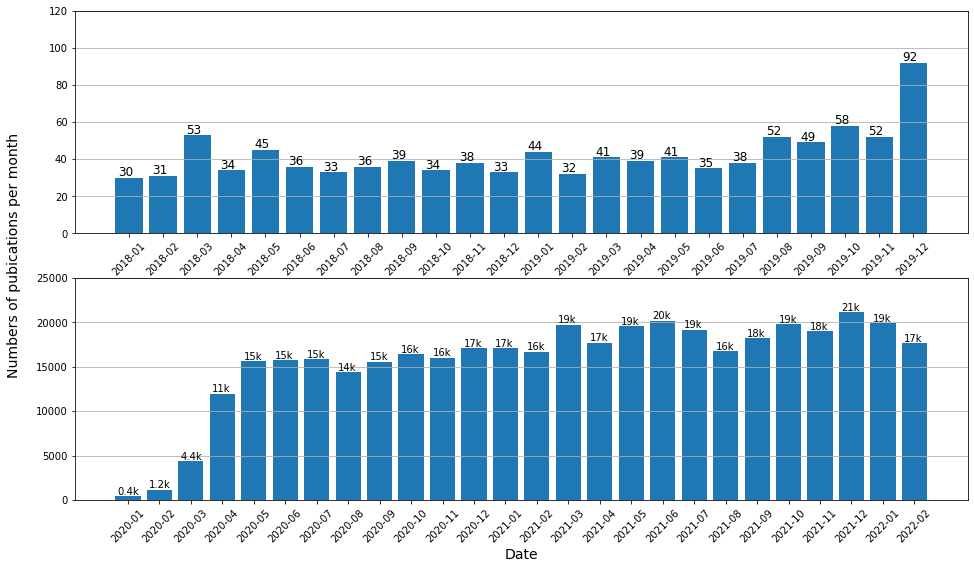

In [379]:
count_df = sub_df[['date','YearMonth']].groupby('YearMonth').count().reset_index()
count_df.columns = ['YearMonth', 'Number of articles']
count_df.YearMonth = count_df.YearMonth.astype(str)
draw_plots(count_df)

### Number of articles per year

In [381]:
sub_df['Year'] = pd.to_datetime(sub_df['date']).dt.to_period('Y')
sub_df

,_id,created,date,YearMonth,Date,Year
0,10.1177/20503121211027778,"{'date-parts': [[2021, 6, 30]], 'date-time': '...",6/30/2021,2021-06,2021-06-30,2021
1,10.1093/ofid/ofaa439.692,"{'date-parts': [[2021, 1, 2]], 'date-time': '2...",1/2/2021,2021-01,2021-01-02,2021
2,10.3390/vaccines9050490,"{'date-parts': [[2021, 5, 12]], 'date-time': '...",5/12/2021,2021-05,2021-05-12,2021
3,10.1093/bjs/znab259.438,"{'date-parts': [[2021, 10, 15]], 'date-time': ...",10/15/2021,2021-10,2021-10-15,2021
4,10.1093/ofid/ofab466.493,"{'date-parts': [[2021, 12, 5]], 'date-time': '...",12/5/2021,2021-12,2021-12-05,2021
...,...,...,...,...,...,...
414057,10.1021/acs.jpclett.0c00994.s002,"{'date-parts': [[2020, 5, 21]], 'date-time': '...",5/21/2020,2020-05,2020-05-21,2020
414058,10.1021/acs.jpclett.0c00994.s001,"{'date-parts': [[2020, 5, 21]], 'date-time': '...",5/21/2020,2020-05,2020-05-21,2020
414059,10.1007/978-3-030-68172-2_10,"{'date-parts': [[2021, 4, 2]], 'date-time': '2...",4/2/2021,2021-04,2021-04-02,2021
414060,10.7717/peerj.12434/fig-6,"{'date-parts': [[2021, 11, 12]], 'date-time': ...",11/12/2021,2021-11,2021-11-12,2021


In [401]:
import math

year_count_df = sub_df[['date','Year']].groupby('Year').count().reset_index()
year_count_df.columns = ['Year', 'Number of articles']
year_count_df.Year = year_count_df.Year.astype(str)
year_count_df['log10'] = year_count_df['Number of articles'].apply(lambda x: round(math.log10(x),3))

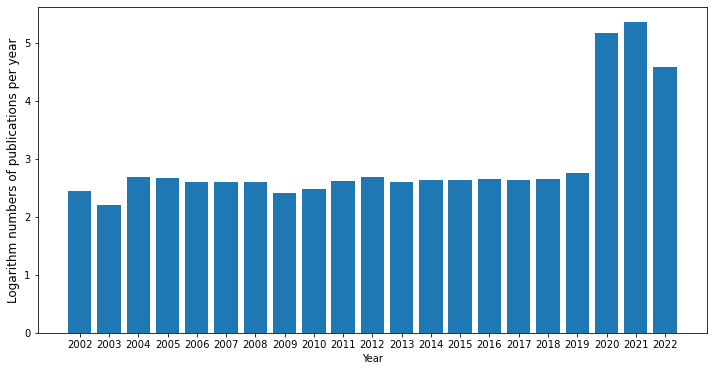

In [400]:

years = list(year_count_df['Year'])
values = list(year_count_df['log10'])
  
fig = plt.figure(figsize = (12,6))
# creating the bar plot
plt.bar(years, values)
 
plt.xlabel("Year")
plt.ylabel("Logarithm numbers of publications per year",fontsize=12)
plt.savefig('../img/article_distribution_per_year.pdf', format='pdf', bbox_inches='tight') 
plt.show()


## Publishers

In [156]:
print(covid_df['publisher'].isnull().sum())
covid_df['publisher'].describe()

170


count          413892
unique           8353
top       Elsevier BV
freq            61744
Name: publisher, dtype: object

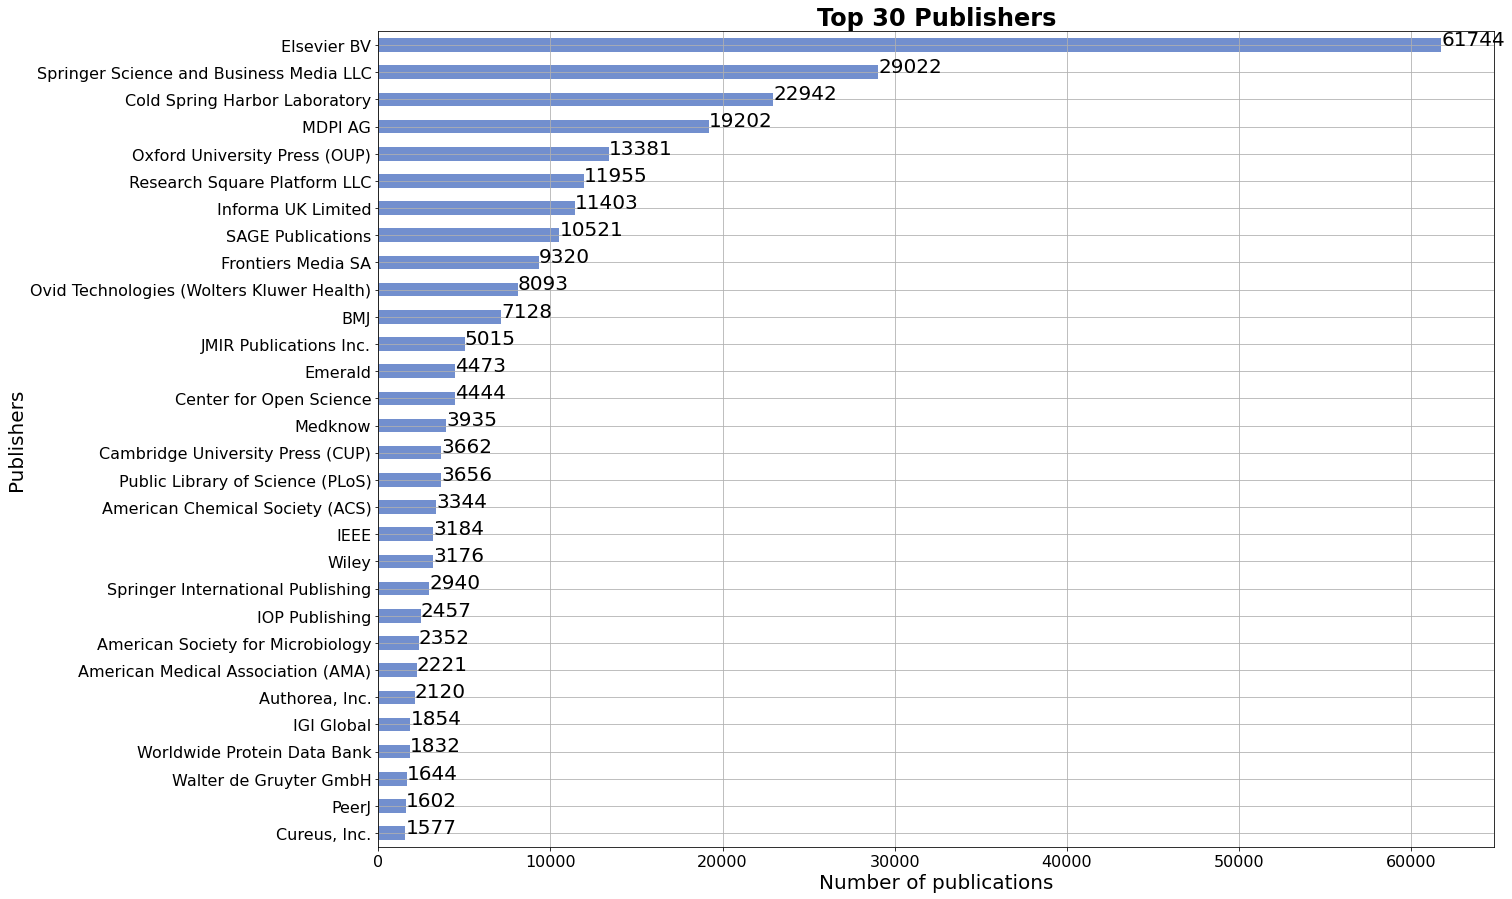

In [157]:
top_n = 30

ax = covid_df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).head(top_n).plot(
    kind='barh', fontsize=16, color='#728FCE',figsize = (20,15))

# top shows biggest value
ax.invert_yaxis() 

# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Publishers', size = 20)
plt.title('Top {} Publishers'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_publishers_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight')  

In [172]:
tmp_df = covid_df.groupby('publisher')['_id'].nunique().sort_values(ascending=False)
tmp_df[:10]

publisher
Elsevier BV                                  61744
Springer Science and Business Media LLC      29022
Cold Spring Harbor Laboratory                22942
MDPI AG                                      19202
Oxford University Press (OUP)                13381
Research Square Platform LLC                 11955
Informa UK Limited                           11403
SAGE Publications                            10521
Frontiers Media SA                            9320
Ovid Technologies (Wolters Kluwer Health)     8093
Name: _id, dtype: int64

## Subjects

In [169]:
num_missing= df['subject'].isnull().sum()

print("{} of pubs missing subject ({}%)".format(num_missing, round(num_missing/len(df)*100), 1))
df['subject'].describe()

177235 of pubs missing subject (43%)


count                   236669
unique                    5935
top       ['General Medicine']
freq                     25197
Name: subject, dtype: object

In [174]:
# find subject usuage

subjects_dict = {}
for index, row in covid_df.iterrows():
    if len(str(row['subject'])) > 3:
        subjects = eval(row['subject'])
        for s in subjects:
            if s in subjects_dict.keys():
                subjects_dict[s] += 1
            else:
                subjects_dict[s] = 1
        
sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
sub_df = pd.DataFrame()
sub_df['Subjects'] = sorted_sub_dict.keys()
sub_df['Number of publications'] = sorted_sub_dict.values()

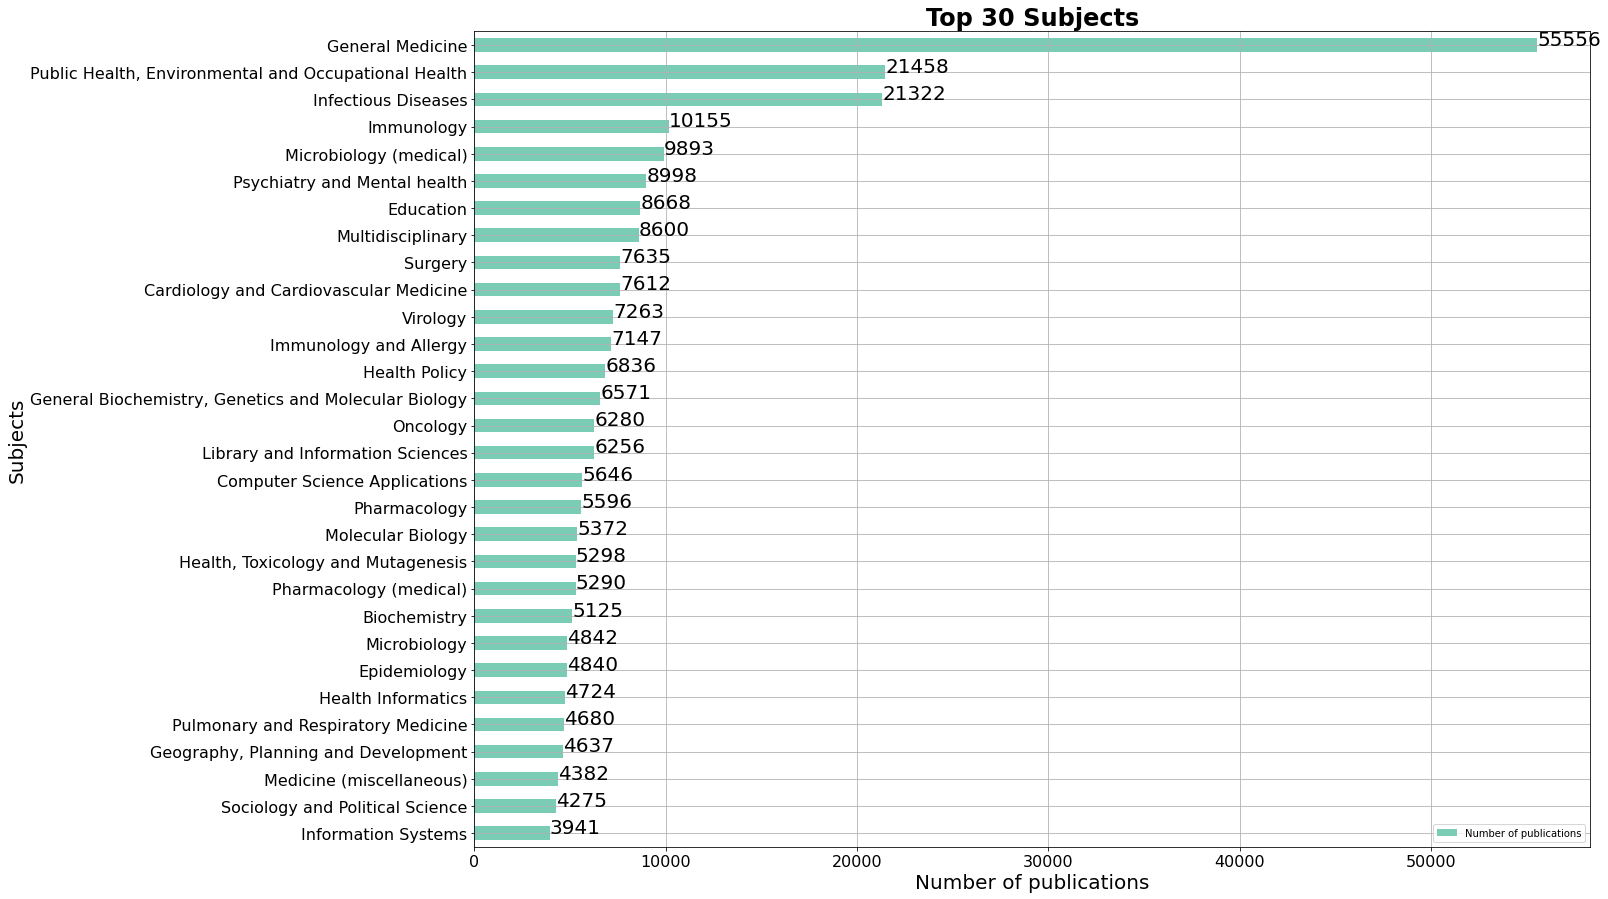

In [120]:
sub_df.index = sub_df['Subjects']
ax = sub_df.head(top_n).plot(
    kind='barh', fontsize=16, color='#7BCCB5',figsize = (20,15))
# top shows biggest value
ax.invert_yaxis() 
# ax.bar_label(ax.containers[0]) 
# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Subjects', size = 20)
plt.title('Top {} Subjects'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_subjects_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight') 

## Container Titles

In [174]:
num_missing= df['container-title'].value_counts()

print("{} of pubs missing container-title ({}%)".format(num_missing[0], round(num_missing[0]/len(df)*100), 1))
df['container-title'].describe()

59728 of pubs missing container-title (14%)


count     413904
unique     35633
top          nan
freq       59728
Name: container-title, dtype: object

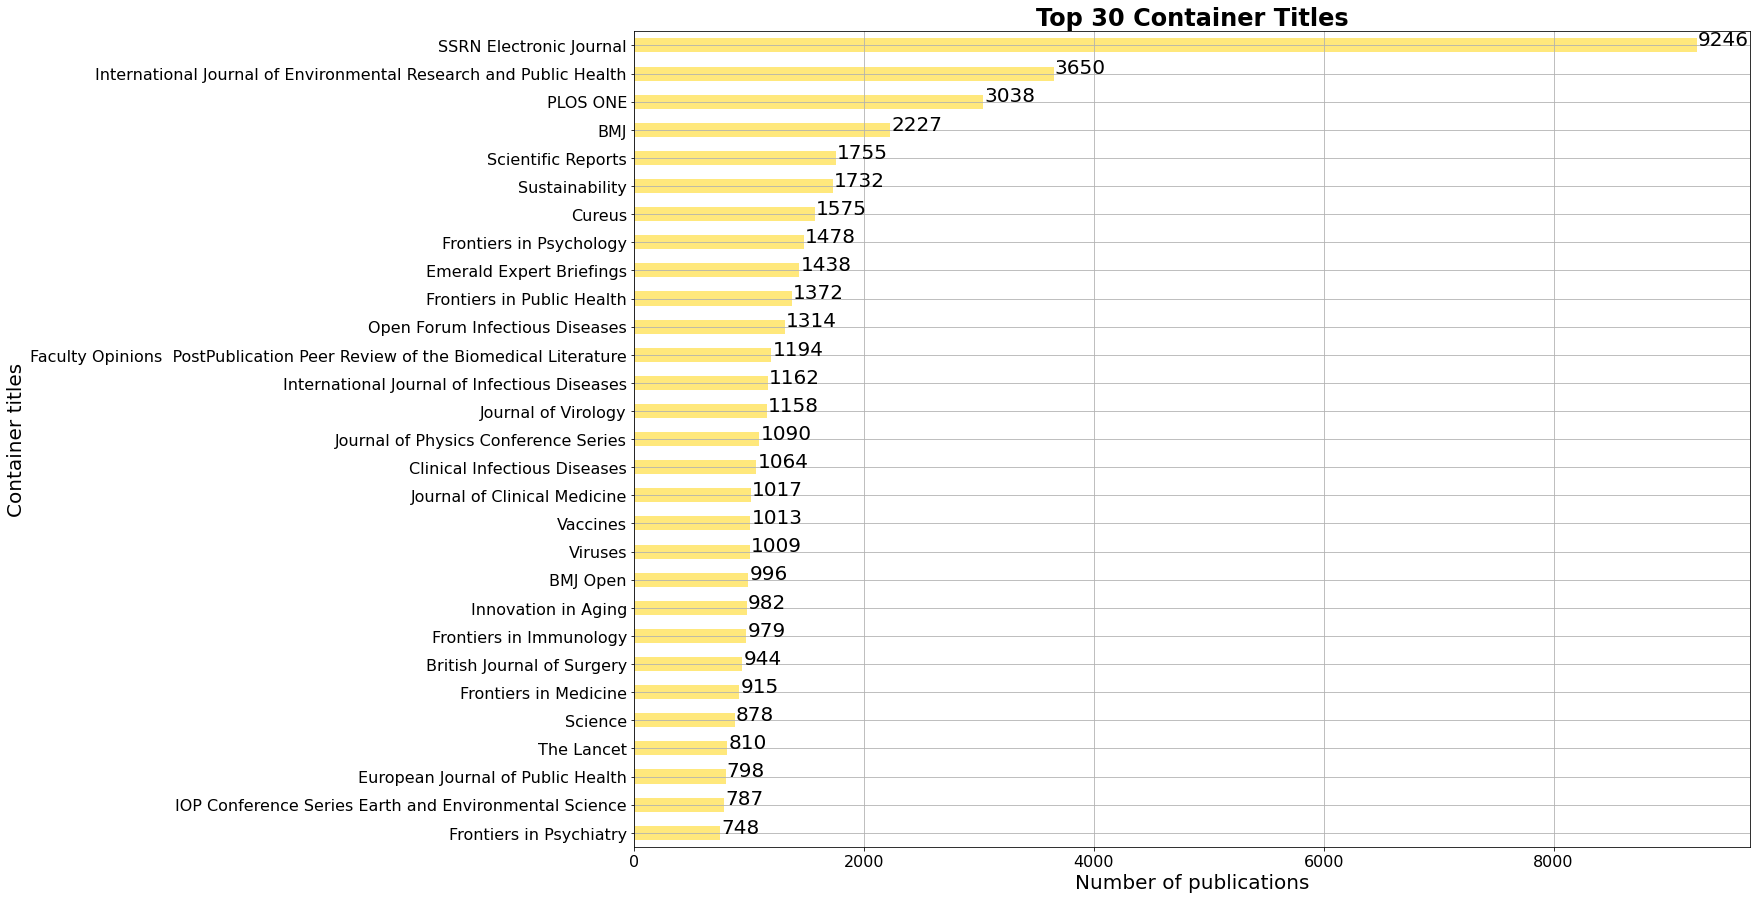

In [156]:
df['container-title'] = df['container-title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r'', str(x)))

ax = covid_df.groupby('container-title')['_id'].nunique().sort_values(ascending=False)[1:top_n].plot(
    kind='barh', fontsize=16, color='#FFE87C',figsize = (20,15))


# top shows biggest value
ax.invert_yaxis() 
# for showing values on bar
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=20)
plt.xlabel('Number of publications', size = 20)
plt.ylabel('Container titles', size = 20)
plt.title('Top {} Container Titles'.format(top_n), size = 24, weight='bold')
plt.grid(True)

plt.savefig('../img/Top_{}_container_titles_barchart.pdf'.format(top_n), format='pdf', bbox_inches='tight') 

## Funders

In [196]:
covid_df['funder'] = covid_df['funder'].astype(str)
num_missing = len(covid_df.covid_df[df['funder'] == 'nan'])

print("{} of pubs missing funder ({}%)".format(num_missing, round(num_missing/len(df)*100), 1))
covid_df['funder'].describe()

363718 of pubs missing funder (88%)


count     413904
unique     41902
top          nan
freq      363718
Name: funder, dtype: object

In [190]:
# find subject usuage

funder_dict = {}
for index, row in covid_df.iterrows():
    if len(str(row['funder'])) > 3:
        funders = eval(row['funder'])
        for f in funders:
            try:
                funder = f['name']
                if funder in funder_dict.keys():
                    funder_dict[funder] += 1
                else:
                    funder_dict[funder] = 1
            except:
                continue
        
sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
funder_df = pd.DataFrame()
funder_df['Funders'] = sorted_funder_dict.keys()
funder_df['Number of publications'] = sorted_funder_dict.values()

## Subplots

In [221]:
publisher_df = covid_df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
publisher_df.columns = ['publisher','Number of publications']

In [249]:
container_df = covid_df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
container_df.columns = ['container_title','Number of publications']
container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
container_df

,container_title,Number of publications
0,SSRN Electronic Journal,9259
1,International Journal of Environmental Researc...,3652
2,PLOS ONE,3039
3,BMJ,2225
4,Scientific Reports,1756
...,...,...
35898,"Gevher Nesibe Journal, IESDR",1
35899,GetMobile: Mobile Computing and Communications,1
35900,Gestão e Sociedade,1
35901,Gestión y Estrategia,1


In [276]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(12,16))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['Subjects'].iloc[:top_n])
    y = list(df2['Number of publications'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[:top_n])
    y = list(df3['Number of publications'].iloc[:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[2].title.set_text("Top container titles")
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[3].title.set_text("Top funders")
    
    plt.savefig('../img/top_{}_articles_metadata.pdf'.format(top_n), format='pdf', bbox_inches='tight')     
    

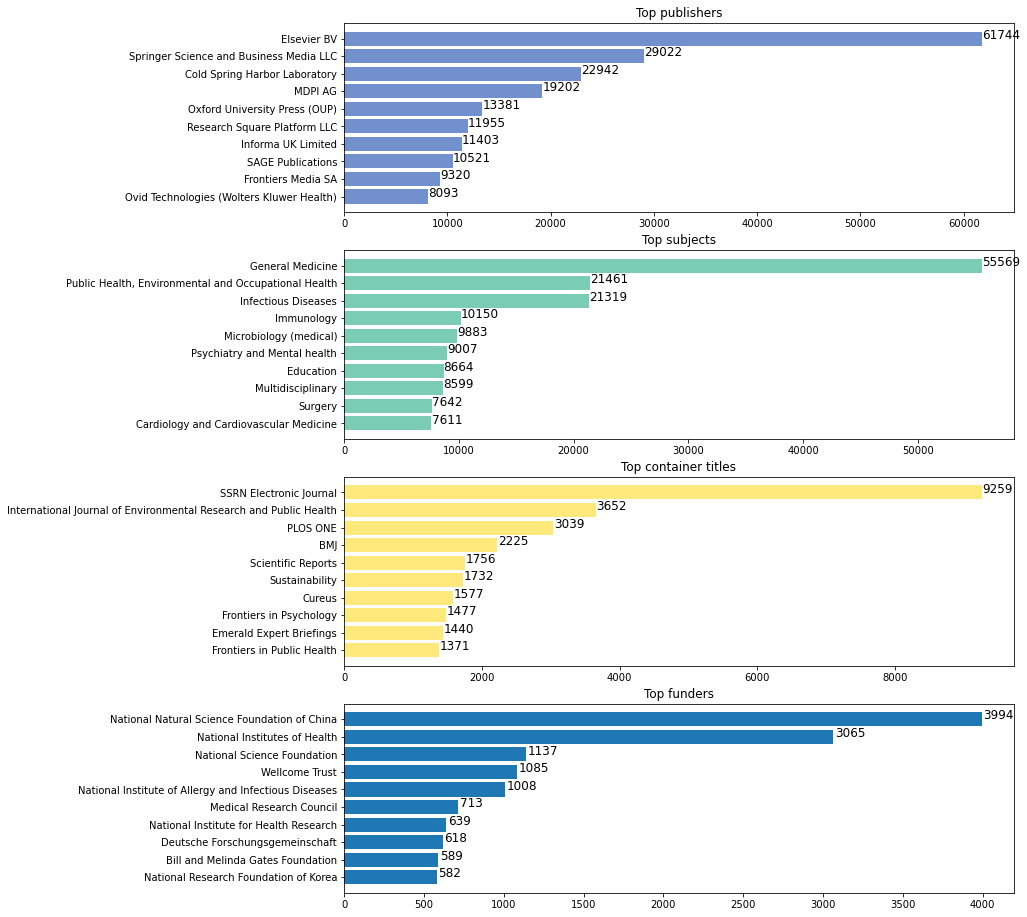

In [277]:
top_n = 10
draw_subplots(top_n, publisher_df, sub_df, container_df, funder_df)